In [1]:
pip install torch torchvision torchaudio numpy matplotlib scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns


In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        img = Image.open(img_path).convert("RGB")  # Convert to RGB
        
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[idx]
        return img, label


In [6]:
# Path to dataset
DATA_PATH = '/kaggle/input/brain-tumor-mri-dataset'
CATEGORIES = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Load file paths and labels
file_paths = []
labels = []

for idx, category in enumerate(CATEGORIES):
    category_path = os.path.join(DATA_PATH, 'Training', category)
    for file_name in os.listdir(category_path):
        file_paths.append(os.path.join(category_path, file_name))
        labels.append(idx)

# Split into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Define image transformations for ResNet input size (224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create PyTorch datasets
train_dataset = BrainTumorDataset(train_paths, train_labels, transform=transform)
val_dataset = BrainTumorDataset(val_paths, val_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet-18 model
model = models.resnet18(pretrained=True)

# Modify the final layer for 4 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(CATEGORIES))

# Send model to device
model = model.to(device)

# Print the model summary
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [9]:
num_epochs = 20
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_accuracy = 100 * correct / total
    train_loss_history.append(total_loss / len(train_loader))
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

# Save the model after training
torch.save(model.state_dict(), "brain_tumor_resnet18.pth")
print("Model saved successfully!")


Epoch 1/20, Loss: 36.0967, Accuracy: 90.87%
Epoch 2/20, Loss: 7.1996, Accuracy: 98.56%
Epoch 3/20, Loss: 3.4754, Accuracy: 99.37%
Epoch 4/20, Loss: 2.0308, Accuracy: 99.72%
Epoch 5/20, Loss: 0.7528, Accuracy: 99.96%
Epoch 6/20, Loss: 0.7218, Accuracy: 99.93%
Epoch 7/20, Loss: 0.6414, Accuracy: 99.93%
Epoch 8/20, Loss: 1.4309, Accuracy: 99.69%
Epoch 9/20, Loss: 2.1583, Accuracy: 99.56%
Epoch 10/20, Loss: 3.5355, Accuracy: 99.12%
Epoch 11/20, Loss: 2.3607, Accuracy: 99.39%
Epoch 12/20, Loss: 2.2177, Accuracy: 99.45%
Epoch 13/20, Loss: 0.9090, Accuracy: 99.85%
Epoch 14/20, Loss: 0.9891, Accuracy: 99.78%
Epoch 15/20, Loss: 0.3352, Accuracy: 99.96%
Epoch 16/20, Loss: 0.7174, Accuracy: 99.87%
Epoch 17/20, Loss: 1.4515, Accuracy: 99.74%
Epoch 18/20, Loss: 0.6472, Accuracy: 99.87%
Epoch 19/20, Loss: 1.0285, Accuracy: 99.74%
Epoch 20/20, Loss: 1.1049, Accuracy: 99.69%
Model saved successfully!


              precision    recall  f1-score   support

      glioma       0.95      0.98      0.96       264
  meningioma       0.98      0.97      0.98       268
   pituitary       0.99      0.96      0.98       292
     notumor       0.99      0.99      0.99       319

    accuracy                           0.98      1143
   macro avg       0.98      0.98      0.98      1143
weighted avg       0.98      0.98      0.98      1143



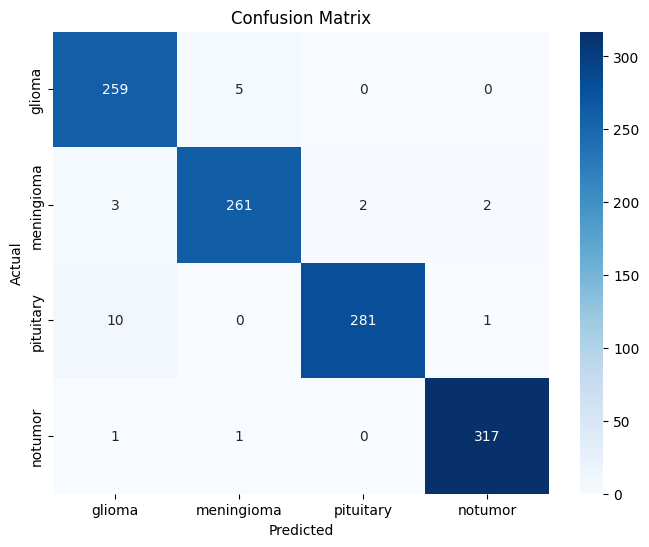

In [10]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate classification report
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC Score (if binary classification)
if len(CATEGORIES) == 2:
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f"ROC-AUC Score: {roc_auc:.4f}")


In [11]:
model.load_state_dict(torch.load("brain_tumor_resnet18.pth", map_location=device))
model.eval()

# Load an image for testing
img = Image.open('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg').convert('RGB')
img = transform(img).unsqueeze(0).to(device)

# Predict
output = model(img)
_, predicted = torch.max(output, 1)
print(f"Predicted class: {CATEGORIES[predicted.item()]}")


Predicted class: meningioma


<ipython-input-11-a38a63be2d16>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("brain_tumor_resnet18.pth", map_location=device))
